## 1. Tải dữ liệu

In [ ]:
!wget --no-check-certificate \
    https://gist.githubusercontent.com/khacanh/4c4662fa226db87a4664dfc2f70bc63e/raw/5d8a1d890c73a1e92e6898137db28f3dc0676975/kieu.txt \
    -O ./kieu.txt

--2023-07-26 11:36:49--  https://gist.githubusercontent.com/khacanh/4c4662fa226db87a4664dfc2f70bc63e/raw/5d8a1d890c73a1e92e6898137db28f3dc0676975/kieu.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135832 (133K) [text/plain]
Saving to: ‘./kieu.txt’

./kieu.txt          100%[===================>] 132.65K  --.-KB/s    in 0.003s  

2023-07-26 11:36:50 (49.3 MB/s) - ‘./kieu.txt’ saved [135832/135832]



Load các dòng thơ

In [ ]:
corpus = []
f = open("kieu.txt", "r")
for line in f:
  corpus.append(line)

In [ ]:
len(corpus)

3254

In [ ]:
corpus[:5]

['Trăm năm trong cõi người ta,\n',
 'Chữ tài chữ mệnh khéo là ghét nhau.\n',
 'Trải qua một cuộc bể dâu,\n',
 'Những điều trông thấy mà đau đớn lòng.\n',
 'Lạ gì bỉ sắc tư phong,\n']

## 2. Xây dựng tokenizer

In [ ]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.preprocessing.text import text_to_word_sequence

In [ ]:
for i in range(len(corpus)):
  corpus[i] = text_to_word_sequence(corpus[i])

In [ ]:
corpus[:5]

[['trăm', 'năm', 'trong', 'cõi', 'người', 'ta'],
 ['chữ', 'tài', 'chữ', 'mệnh', 'khéo', 'là', 'ghét', 'nhau'],
 ['trải', 'qua', 'một', 'cuộc', 'bể', 'dâu'],
 ['những', 'điều', 'trông', 'thấy', 'mà', 'đau', 'đớn', 'lòng'],
 ['lạ', 'gì', 'bỉ', 'sắc', 'tư', 'phong']]

In [ ]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(corpus)
w2id = tokenizer.word_index

In [ ]:
len(w2id)

2407

In [ ]:
from keras.utils import to_categorical

## 3. Xử lý dữ liệu cho CBOW

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
window_size = 2
vocab_size

2408

In [ ]:
import numpy as np
def generate_pairs(window_size, corpus):
  """
  Tiến hành lấy 1 từ khỏi câu làm nhãn và sử dụng câu bao
  gồm k từ bên trái và k từ bên phải (trường hợp này window_size = k) làm đầu vào

  Đầu vào:
    window_size:
      Dạng: Python integer
      Miêu tả: k từ bên trái/phải được giữ lại
    corpus:
      Dạng: Python Dictionary
      Miêu tả: từ điển nối từ và id
  """
  X = []
  y = []
  for words in corpus:
    start = 0
    while start + window_size * 2 < len(words):
      end = start + window_size * 2
      tar_i = start + window_size

      # Lựa chọn từ ở vị trí hiện tại làm nhãn
      label = words[tar_i]

      # Nối k từ bên trái và k từ bên phải của từ này thành 1 câu
      x = [" ".join(words[start:tar_i] + words[tar_i+1:end+1])]

      print(words)
      print(x, "--->", label)
      start += 1
      X.append(tokenizer.texts_to_sequences(x)[0])
      y.append(tokenizer.word_index[label])

  return tf.convert_to_tensor(X) , tf.convert_to_tensor(y)

In [ ]:
X_train, y_train = generate_pairs(window_size, corpus)

In [ ]:
X_train.numpy()

array([[143,  77, 498,   4],
       [ 77,  27,   4,  66],
       [126, 127, 374, 351],
       ...,
       [240,  10,   2, 332],
       [ 10,  89, 332, 755],
       [ 89,   2, 755, 304]], dtype=int32)

In [ ]:
y_train.numpy()

array([ 27, 498, 126, ...,  89,   2, 332], dtype=int32)

## 4. Xây dựng mô hình

Mô hình CBOW bao gồm
- 1 lớp Embedding với chiều được định sẵn
- 1 lớp Dense để phóng về chiều từ điển

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.backend import mean


Kiểm tra mô hình

In [ ]:
embedding_size = 128
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: mean(x, axis=1), output_shape=(embedding_size,) ))
cbow.add(Dense(vocab_size, activation='softmax'))

In [ ]:
cbow.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 4, 128)            308224    
                                                                 
 lambda_3 (Lambda)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 2408)              310632    
                                                                 
Total params: 618,856
Trainable params: 618,856
Non-trainable params: 0
_________________________________________________________________


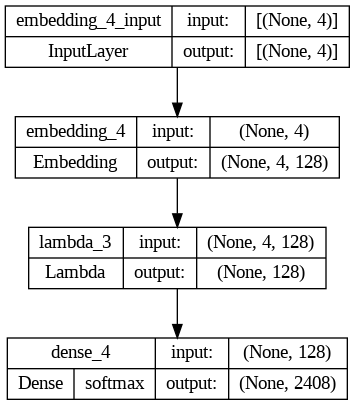

In [84]:
from keras.utils import plot_model

plot_model(cbow, show_shapes=True, show_layer_activations=True)

## 5. Tiến hành training

In [ ]:
cbow.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
cbow.fit(X_train, y_train, epochs=100, verbose=1)

Epoch 1/100
306/306 [==============================] - 5s 16ms/step - loss: 7.4310 - acc: 0.0202
Epoch 2/100
306/306 [==============================] - 2s 5ms/step - loss: 6.7708 - acc: 0.0204
Epoch 3/100
306/306 [==============================] - 2s 6ms/step - loss: 6.6713 - acc: 0.0204
Epoch 4/100
306/306 [==============================] - 1s 5ms/step - loss: 6.6008 - acc: 0.0220
Epoch 5/100
306/306 [==============================] - 1s 4ms/step - loss: 6.5162 - acc: 0.0225
Epoch 6/100
306/306 [==============================] - 1s 4ms/step - loss: 6.4082 - acc: 0.0303
Epoch 7/100
306/306 [==============================] - 1s 4ms/step - loss: 6.2692 - acc: 0.0403
Epoch 8/100
306/306 [==============================] - 1s 4ms/step - loss: 6.0925 - acc: 0.0526
Epoch 9/100
306/306 [==============================] - 1s 4ms/step - loss: 5.8755 - acc: 0.0640
Epoch 10/100
306/306 [==============================] - 1s 5ms/step - loss: 5.6245 - acc: 0.0793
Epoch 11/100
306/306 [================

6. Kiểm tra sinh từ

In [ ]:
example = 'Trăm năm cõi người'
example = text_to_word_sequence(example)
example = tokenizer.texts_to_sequences([example])
example = tf.convert_to_tensor(example)
cbow.predict(example)
tokenizer.index_word[np.argmax(cbow.predict(example))]

1/1 [==============================] - 0s 20ms/step


'trong'

## 6. Hiển thị Embedding

In [ ]:
weights = cbow.get_weights()[0]

In [ ]:
weights.shape

(2408, 128)

In [ ]:
import pandas as pd
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(tokenizer.index_word.values())).head()

(2407, 128)


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
<OOV>,-1.236698,0.201824,0.572101,0.125164,-0.811192,-0.120448,-0.918842,0.803646,0.648930,0.917917,...,-0.119426,-0.407833,-0.624822,0.201848,-0.227911,-0.145733,-0.059845,-1.695303,-0.195441,0.106188
một,-1.406773,-0.938034,-0.002239,-2.408614,-1.278805,-0.951506,0.199969,-1.253052,-0.923205,1.055947,...,-1.227864,-0.578797,2.301090,0.748831,0.532190,0.234105,-0.320095,1.788026,0.492142,0.099150
đã,0.616364,-3.106002,0.150707,-0.625102,-0.684270,-0.426016,1.002890,0.303251,-0.208308,0.440750,...,-0.340602,1.433327,-1.517547,0.446074,-0.488917,0.456823,0.549649,-0.314763,0.975547,-1.336631
người,0.446240,0.161893,-0.516017,-1.294341,1.447320,-0.007344,-0.439106,-0.240124,-0.661176,-2.357723,...,-0.963069,-0.977101,0.251281,1.054641,0.664057,-2.176433,-0.561507,0.107915,0.952061,1.283490
nàng,-0.131963,0.529943,0.047270,1.281149,-0.969978,0.568849,0.164120,0.572200,1.040143,0.239382,...,-2.042561,0.859989,0.753209,-0.176652,-2.449202,0.928226,0.145531,-0.240821,0.208140,-0.098439
